In [ ]:
infolder, outfolder = find_folder()
trigs=list(range(101, 151))+list(range(201, 251))
#trigs=list(range(101, 151))
event_ids={str(x):x for x in trigs}
im_times=(-0.1,1)
filt=(0.03,200)
subs = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
np.random.seed(10)
n_perm = 20  # number of permutations
n_pseudo = 11  # number of pseudo-trials
results = compute_combined(folder, subs, filt, im_times, event_ids)
    
    

In [ ]:
%run general_tools.ipynb
import
infolder, outfolder = find_folder()
trigs=list(range(101, 151))+list(range(201, 251))
#trigs=list(range(101, 151))
event_ids={str(x):x for x in trigs}
im_times=(-0.1,1)
filt=(0.03,200)
subs = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
subs = [18]
np.random.seed(10)
n_perm = 20  # number of permutations
n_pseudo = 11  # number of pseudo-trials
results = compute_time(infolder, subs, filt, im_times, event_ids)

In [14]:
%run general_tools.ipynb
%run EEG_auxiliary_module.ipynb
%run make_features.ipynb
from pathlib import Path, PurePath
import numpy as np
import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import os
import scipy
from sklearn.discriminant_analysis import _cov
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
np.random.seed(10)

pick_ch=['P9','P7','P5','P3','PO7','PO3','O1','P10','P8','P6','P4','PO8','PO4','O2','POz','Pz']
#pick_ch=['PO8','PO7']

infolder, outfolder = find_folder()
trigs=list(range(101, 151))+list(range(201, 251))
#trigs=list(range(101, 151))
event_ids={str(x):x for x in trigs}
im_times=(-0.1,1)
filt=(0.03,200)
subs = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
subs = [2]

n_perm = 20  # number of permutations
n_pseudo = 11  # number of pseudo-trials

svm = SVC(kernel='linear')
CV = ShuffleBinLeaveOneOut

out = list()
for i,sub in enumerate(subs):
    update_progress(i/len(subs))
    fnames = [infolder+'\\IR_'+str(sub).zfill(2)+'_S01.bdf',infolder+'\\IR_'+str(sub).zfill(2)+'_S02.bdf']
    epochs = load_to_epochs_perc(fnames, event_ids, im_times, filt)
    epochs.drop_channels(['Status']).equalize_event_counts(event_ids=event_ids, method='mintime')
    X = epochs.get_data()
    y = epochs.events[:, 2]
    y = [a-101 if a<200 else a-151 for a in y]
    n_conditions = len(np.unique(y))
    n_sensors = X.shape[1]
    n_time = X.shape[2]
    cv = CV(y, n_iter=n_perm, n_pseudo=n_pseudo)
    result = np.full((n_perm, n_conditions, n_conditions), np.nan)
    for f, (train_indices, test_indices) in enumerate(cv.split(X)):
                print('\tPermutation %g / %g' % (f + 1, n_perm))

                # 1. Compute pseudo-trials for training and test
                Xpseudo_train = np.full((len(train_indices), n_sensors, n_time), np.nan)
                Xpseudo_test = np.full((len(test_indices), n_sensors, n_time), np.nan)
                for i, ind in enumerate(train_indices):
                    Xpseudo_train[i, :, :] = np.mean(X[ind, :, :], axis=0)
                for i, ind in enumerate(test_indices):
                    Xpseudo_test[i, :, :] = np.mean(X[ind, :, :], axis=0)


                # 2. Whitening using the Epoch method
                sigma_conditions = cv.labels_pseudo_train[0, :, n_pseudo-1:].flatten()
                sigma_ = np.empty((n_conditions, n_sensors, n_sensors))
                for k,c in enumerate(np.unique(y)):
                    # compute sigma for each time point, then average across time
                    sigma_[k] = np.mean([_cov(Xpseudo_train[sigma_conditions==c, :, t], shrinkage='auto')
                                         for t in range(n_time)], axis=0)
                sigma = sigma_.mean(axis=0)  # average across conditions
                sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)
                Xpseudo_train = (Xpseudo_train.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)
                Xpseudo_test = (Xpseudo_test.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)

                for c1 in range(n_conditions-1):
                    for c2 in range(min(c1 + 1, n_conditions-1), n_conditions):
                            # 3. Fit the classifier using training data
                            data_train = Xpseudo_train[cv.ind_pseudo_train[c1, c2], :, :]
                            data_train = np.reshape(data_train, (data_train.shape[0], data_train.shape[1]*data_train.shape[2]), order='F')
                            svm.fit(data_train, cv.labels_pseudo_train[c1, c2])                            

                            # 4. Compute and store classification accuracies
                            data_test = Xpseudo_test[cv.ind_pseudo_test[c1, c2], :, :]
                            data_test = np.reshape(data_test, (data_test.shape[0], data_test.shape[1]*data_test.shape[2]), order='F')
                            result[f, c1, c2] = np.mean(svm.predict(data_test) == cv.labels_pseudo_test[c1, c2]) - 0.5                            

        # average across permutations
    out.append(result)
    from scipy.spatial.distance import squareform
    a = np.nanmean(result,axis=0)[:50,:50]
    np.nanmean(a)

Progress: [--------------------] 0.0%
Extracting EDF parameters from E:\Ilya_study\Data\IR_02_S01.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3385855  =      0.000 ...  6612.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.03 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.03, 200.00 Hz: -6.02, -6.02 dB

2500 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 2500 events and 564 original time points ...
0 bad epochs dropped
Extracting EDF parameters from E:\Ilya_study\Data\IR_02_S02.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2043391  =      0.000 ...  3990.998 secs...
Filtering raw data in 1 

C:\Users\danne\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: Mean of empty slice


In [27]:
np.savez_compressed('acc_perc_all',results=out)

In [25]:
out = list()
out.append(result)
for i in results:
    out.append(i)
len(out)

17

In [16]:
import numpy as np
loaded = np.load('perc_all_discr.npz')
results = loaded['out']

In [33]:
for i in out:
    print(np.nanmean(i[:,:25,:25]))

0.10266666666666667
0.030333333333333334
0.0915
0.23883333333333334
0.13691666666666666
0.2703333333333333
0.22833333333333333
0.103
0.05433333333333333
0.34758333333333336
0.21691666666666667
0.19275
0.24458333333333335
0.37983333333333336
0.2743333333333333
0.33316666666666667
0.21558333333333332


In [66]:
%run general_tools.ipynb
%run EEG_auxiliary_module.ipynb
%run make_features.ipynb
from pathlib import Path, PurePath
import numpy as np
import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
np.random.seed(10)

pick_ch=['P9','P7','P5','P3','PO7','PO3','O1','P10','P8','P6','P4','PO8','PO4','O2','POz','Pz']
#pick_ch=['PO8','PO7']

infolder, outfolder = find_folder()
trigs=list(range(101, 151))+list(range(201, 251))
#trigs=list(range(101, 151))
event_ids={str(x):x for x in trigs}
im_times=(-0.1,1)
filt=(0.03,200)
fnames = ['E:\\Ilya_study\\Data\\IR_06_S01.bdf','E:\\Ilya_study\\Data\\IR_06_S02.bdf']
epochs = load_to_epochs_perc(fnames, event_ids, im_times, filt)
epochs.drop_channels(['Status']).equalize_event_counts(event_ids=event_ids, method='mintime')
#epochs = block_average(epochs,4,12, kind='perc',zscore = False)
pick_ch = mne.pick_channels(epochs.ch_names, pick_ch)
#data = epochs.get_data()[:, pick_ch, :]
X = epochs.get_data()
y = epochs.events[:, 2]
y = [a-101 if a<200 else a-151 for a in y]

TRAIN: [ 5  7  9 11] TEST: [0 2]
y_TRAIN: ['r2_A2' 'r2_B2' 'r3_A2' 'r3_B2'] y_TEST: ['r1_A1' 'r1_B1']
TRAIN: [ 1  3  9 11] TEST: [4 6]
y_TRAIN: ['r1_A2' 'r1_B2' 'r3_A2' 'r3_B2'] y_TEST: ['r2_A1' 'r2_B1']
TRAIN: [1 3 5 7] TEST: [ 8 10]
y_TRAIN: ['r1_A2' 'r1_B2' 'r2_A2' 'r2_B2'] y_TEST: ['r3_A1' 'r3_B1']
TRAIN: [ 4  6  8 10] TEST: [1 3]
y_TRAIN: ['r2_A1' 'r2_B1' 'r3_A1' 'r3_B1'] y_TEST: ['r1_A2' 'r1_B2']
TRAIN: [ 0  2  8 10] TEST: [5 7]
y_TRAIN: ['r1_A1' 'r1_B1' 'r3_A1' 'r3_B1'] y_TEST: ['r2_A2' 'r2_B2']
TRAIN: [0 2 4 6] TEST: [ 9 11]
y_TRAIN: ['r1_A1' 'r1_B1' 'r2_A1' 'r2_B1'] y_TEST: ['r3_A2' 'r3_B2']
TRAIN: [ 5  6  9 10] TEST: [0 3]
y_TRAIN: ['r2_A2' 'r2_B1' 'r3_A2' 'r3_B1'] y_TEST: ['r1_A1' 'r1_B2']
TRAIN: [ 1  2  9 10] TEST: [4 7]
y_TRAIN: ['r1_A2' 'r1_B1' 'r3_A2' 'r3_B1'] y_TEST: ['r2_A1' 'r2_B2']
TRAIN: [1 2 5 6] TEST: [ 8 11]
y_TRAIN: ['r1_A2' 'r1_B1' 'r2_A2' 'r2_B1'] y_TEST: ['r3_A1' 'r3_B2']
TRAIN: [ 4  7  8 11] TEST: [1 2]
y_TRAIN: ['r2_A1' 'r2_B2' 'r3_A1' 'r3_B2'] y_TEST: ['r1

In [61]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [67]:
import os

import numpy as np
import scipy
from sklearn.discriminant_analysis import _cov
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Parameters
n_perm = 20  # number of permutations
n_pseudo = 12  # number of pseudo-trials
n_conditions = len(np.unique(y))
n_sensors = X.shape[1]
n_time = X.shape[2]

In [68]:
svm = SVC(kernel='linear')
CV = ShuffleBinLeaveOneOut
cv = CV(y, n_iter=n_perm, n_pseudo=n_pseudo)
result = np.full((n_perm, n_conditions, n_conditions, n_time), np.nan)

In [ ]:
for f, (train_indices, test_indices) in enumerate(cv.split(X)):
            print('\tPermutation %g / %g' % (f + 1, n_perm))

            # 1. Compute pseudo-trials for training and test
            Xpseudo_train = np.full((len(train_indices), n_sensors, n_time), np.nan)
            Xpseudo_test = np.full((len(test_indices), n_sensors, n_time), np.nan)
            for i, ind in enumerate(train_indices):
                Xpseudo_train[i, :, :] = np.mean(X[ind, :, :], axis=0)
            for i, ind in enumerate(test_indices):
                Xpseudo_test[i, :, :] = np.mean(X[ind, :, :], axis=0)


            # 2. Whitening using the Epoch method
            sigma_conditions = cv.labels_pseudo_train[0, :, n_pseudo-1:].flatten()
            sigma_ = np.empty((n_conditions, n_sensors, n_sensors))
            for k,c in enumerate(np.unique(y)):
                # compute sigma for each time point, then average across time
                sigma_[k] = np.mean([_cov(Xpseudo_train[sigma_conditions==c, :, t], shrinkage='auto')
                                     for t in range(n_time)], axis=0)
            sigma = sigma_.mean(axis=0)  # average across conditions
            sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)
            Xpseudo_train = (Xpseudo_train.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)
            Xpseudo_test = (Xpseudo_test.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)

            for t in range(n_time):
                for c1 in range(n_conditions-1):
                    for c2 in range(min(c1 + 1, n_conditions-1), n_conditions):
                            # 3. Fit the classifier using training data
                            data_train = Xpseudo_train[cv.ind_pseudo_train[c1, c2], :, t]
                            svm.fit(data_train, cv.labels_pseudo_train[c1, c2])                            

                            # 4. Compute and store classification accuracies
                            data_test = Xpseudo_test[cv.ind_pseudo_test[c1, c2], :, t]
                            result[f, c1, c2, t] = np.mean(svm.predict(data_test) == cv.labels_pseudo_test[c1, c2]) - 0.5                            
                           
    # average across permutations

       

In [70]:
np.save( 'cum_accuracy_06.npy', result)

In [80]:
temp = np.load('C:\\Users\\danne\\Documents\Codes\\EEG_analysis\\result_decoding_time.npy')
temp.shape

(20, 100, 100, 564)

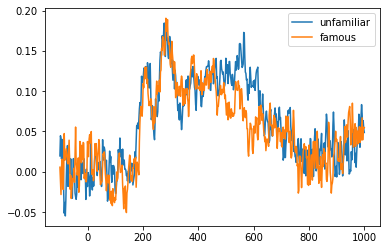

In [87]:
temp = np.load('C:\\Users\\danne\\Documents\Codes\\EEG_analysis\\result_decoding_time.npy')
temp1 = np.nanmean(temp[:,:25,:25,:], axis=(0,1,2))
temp2 = np.nanmean(temp[:,25:50,25:50,:], axis=(0,1,2))
temp.shape
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.linspace(-100,1000,564),temp1, label='unfamiliar')
plt.plot(np.linspace(-100,1000,564),temp2, label='famous')
plt.legend()
plt.savefig('sub6.png')

In [69]:
result = np.full((n_perm, n_conditions, n_conditions), np.nan)
for f, (train_indices, test_indices) in enumerate(cv.split(X)):
            print('\tPermutation %g / %g' % (f + 1, n_perm))

            # 1. Compute pseudo-trials for training and test
            Xpseudo_train = np.full((len(train_indices), n_sensors, n_time), np.nan)
            Xpseudo_test = np.full((len(test_indices), n_sensors, n_time), np.nan)
            for i, ind in enumerate(train_indices):
                Xpseudo_train[i, :, :] = np.mean(X[ind, :, :], axis=0)
            for i, ind in enumerate(test_indices):
                Xpseudo_test[i, :, :] = np.mean(X[ind, :, :], axis=0)


            # 2. Whitening using the Epoch method
            sigma_conditions = cv.labels_pseudo_train[0, :, n_pseudo-1:].flatten()
            sigma_ = np.empty((n_conditions, n_sensors, n_sensors))
            for k,c in enumerate(np.unique(y)):
                # compute sigma for each time point, then average across time
                sigma_[k] = np.mean([_cov(Xpseudo_train[sigma_conditions==c, :, t], shrinkage='auto')
                                     for t in range(n_time)], axis=0)
            sigma = sigma_.mean(axis=0)  # average across conditions
            sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)
            Xpseudo_train = (Xpseudo_train.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)
            Xpseudo_test = (Xpseudo_test.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)

            for c1 in range(n_conditions-1):
                for c2 in range(min(c1 + 1, n_conditions-1), n_conditions):
                        # 3. Fit the classifier using training data
                        data_train = Xpseudo_train[cv.ind_pseudo_train[c1, c2], :, :]
                        data_train = np.reshape(data_train, (data_train.shape[0], data_train.shape[1]*data_train.shape[2]), order='F')
                        svm.fit(data_train, cv.labels_pseudo_train[c1, c2])                            

                        # 4. Compute and store classification accuracies
                        data_test = Xpseudo_test[cv.ind_pseudo_test[c1, c2], :, :]
                        data_test = np.reshape(data_test, (data_test.shape[0], data_test.shape[1]*data_test.shape[2]), order='F')
                        result[f, c1, c2] = np.mean(svm.predict(data_test) == cv.labels_pseudo_test[c1, c2]) - 0.5                            
                           
    # average across permutations
from scipy.spatial.distance import squareform
a = np.nanmean(result,axis=0)[:50,:50]
np.nanmean(a)

	Permutation 1 / 20
	Permutation 2 / 20
	Permutation 3 / 20
	Permutation 4 / 20
	Permutation 5 / 20
	Permutation 6 / 20
	Permutation 7 / 20
	Permutation 8 / 20
	Permutation 9 / 20
	Permutation 10 / 20
	Permutation 11 / 20
	Permutation 12 / 20
	Permutation 13 / 20
	Permutation 14 / 20
	Permutation 15 / 20
	Permutation 16 / 20
	Permutation 17 / 20
	Permutation 18 / 20
	Permutation 19 / 20
	Permutation 20 / 20


C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


0.17004081632653056

C:\Users\danne\Anaconda3\envs\eeg_analysis\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


0.27620408163265303

In [58]:
np.nanmean(result[7,:10,:10])

0.1

We set a seed, in order to make analyses reproducible:

Let's load some data:

In [ ]:
root = '' # This is the /path/to the directory containing the data.
          # We leave it empty here, because the data is located in the current directory.

# Load data and trial labels for the two sessions of participant 01
sessions = [
    # Session 1
    dict(
        data=np.load(os.path.join(root, 'data01_sess1.npy')),
        # data has shape n_trials x n_sensors x n_timepoints
        labels=np.load(os.path.join(root, 'labels01_sess1.npy'))
        # labels has shape 1 x n_trials (i.e., one condition label [object category] per trial)
    ),
    # Session 2
    dict(
        data=np.load(os.path.join(root, 'data01_sess2.npy')),
        labels=np.load(os.path.join(root, 'labels01_sess2.npy'))
    )
]

Now we set some parameters. Only the number of permutations and the number of pseudo-trials are free parameters. The number of conditions, sensors, time points and sessions are derived from the data (i.e., from the `sessions` variable above).

In [ ]:

n_sessions = len(sessions)

We define three classifiers that will be compared: Support Vector Machine, Gaussian Naive Bayes and the [Weighted Robust Distance](https://github.com/m-guggenmos/weird). We provide the code for Linear Discriminant Analysis only in comments, as it is quite slow in this scikit-learn Python implementation.

In [ ]:

gnb = GaussianNB()
weird = WeiRD()
# lda = LDA(sigma=np.eye(n_sensors))  # passing identitity covariance matrix to LDA, since data is pre-whitened

We choose our partitioning scheme, here `ShuffleBinLeaveOneOut`. This class will provide the trial-to-pseudo-trial assignments for each permutation. We'll define the class object already at this point:

In [ ]:
# Choose data partitioning scheme


The analytic logic is contained in a nested for loop, with loops for the number of sessions, number of permutations, number of timepoints, number of conditions, and number of conditions again. Overall, the logic contains 4 crucial steps:
1. Compute pseudo-trials for the training and test data
2. Whiten the training data (here using the Epoch method, which is recommended in our manuscript)
3. Fit the classifier to the training data
4. Compute classification accuracy on test data

In [ ]:
# pre-load mechanism, for convenience
preload_result = True # for recomputing the decoding analyses, set to False
if preload_result:
    result = np.load(os.path.join(root, 'result_decoding.npy'))
else:
    result = np.full((n_sessions, n_perm, n_conditions, n_conditions, n_time), np.nan,
                     dtype={'names': ['svm', 'gnb', 'weird', 'lda'], 'formats': 4*['f8']})

    for s, session in enumerate(sessions):

        print('Session %g / %g' % (s + 1, n_sessions))

        X = session['data']
        y = session['labels']

        cv = CV(y, n_iter=n_perm, n_pseudo=n_pseudo)

        for f, (train_indices, test_indices) in enumerate(cv.split(X)):
            print('\tPermutation %g / %g' % (f + 1, n_perm))

            # 1. Compute pseudo-trials for training and test
            Xpseudo_train = np.full((len(train_indices), n_sensors, n_time), np.nan)
            Xpseudo_test = np.full((len(test_indices), n_sensors, n_time), np.nan)
            for i, ind in enumerate(train_indices):
                Xpseudo_train[i, :, :] = np.mean(X[ind, :, :], axis=0)
            for i, ind in enumerate(test_indices):
                Xpseudo_test[i, :, :] = np.mean(X[ind, :, :], axis=0)


            # 2. Whitening using the Epoch method
            sigma_conditions = cv.labels_pseudo_train[0, :, n_pseudo-1:].flatten()
            sigma_ = np.empty((n_conditions, n_sensors, n_sensors))
            for c in range(n_conditions):
                # compute sigma for each time point, then average across time
                sigma_[c] = np.mean([_cov(Xpseudo_train[sigma_conditions==c, :, t], shrinkage='auto')
                                     for t in range(n_time)], axis=0)
            sigma = sigma_.mean(axis=0)  # average across conditions
            sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)
            Xpseudo_train = (Xpseudo_train.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)
            Xpseudo_test = (Xpseudo_test.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)

            for t in range(n_time):
                for c1 in range(n_conditions-1):
                    for c2 in range(min(c1 + 1, n_conditions-1), n_conditions):
                            # 3. Fit the classifier using training data
                            data_train = Xpseudo_train[cv.ind_pseudo_train[c1, c2], :, t]
                            svm.fit(data_train, cv.labels_pseudo_train[c1, c2])                            
                            gnb.fit(data_train, cv.labels_pseudo_train[c1, c2])
                            weird.fit(data_train, cv.labels_pseudo_train[c1, c2])
                            # lda.fit(data_train, cv.labels_pseudo_train[c1, c2])

                            # 4. Compute and store classification accuracies
                            data_test = Xpseudo_test[cv.ind_pseudo_test[c1, c2], :, t]
                            result['svm'][s, f, c1, c2, t] = np.mean(svm.predict(data_test) == cv.labels_pseudo_test[c1, c2]) - 0.5                            
                            result['gnb'][s, f, c1, c2, t] = np.mean(gnb.predict(data_test) == cv.labels_pseudo_test[c1, c2]) - 0.5
                            result['weird'][s, f, c1, c2, t] = np.mean(weird.predict(data_test) == cv.labels_pseudo_test[c1, c2]) - 0.5
                            # result['lda'][s, f, c1, c2, t] = np.mean(lda.predict(data_test) == cv.labels_pseudo_test[c1, c2]) - 0.5
    # average across permutations
    result_ = np.full((n_sessions, n_conditions, n_conditions, n_time), np.nan,
                      dtype={'names': ['svm', 'gnb', 'weird', 'lda'], 'formats': 4*['f8']})    
    result_['svm'] = np.nanmean(result['svm'], axis=1)
    result_['gnb'] = np.nanmean(result['gnb'], axis=1)
    result_['weird'] = np.nanmean(result['weird'], axis=1)
    # result_['lda'] = np.nanmean(result['lda'], axis=1)
    result = result_
    np.save(os.path.join(root, 'result_decoding.npy'), result)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

Now we plot the average classification accuracy time course by collapsing across sessions and conditions:

In [ ]:
plt.plot(np.arange(-100, 1001, 10), 100*np.nanmean(result['svm'], axis=(0, 1, 2))+50, label='SVM')
plt.plot(np.arange(-100, 1001, 10), 100*np.nanmean(result['gnb'], axis=(0, 1, 2))+50, label='GNB')
plt.plot(np.arange(-100, 1001, 10), 100*np.nanmean(result['weird'], axis=(0, 1, 2))+50, label='WeiRD')
if 'lda' in result.dtype.names:
    plt.plot(np.arange(-100, 1001, 10), 100*np.nanmean(result['lda'], axis=(0, 1, 2))+50, label='LDA')
plt.plot([-100, 1000], [50, 50], 'k-')
plt.xlim((-100, 1000))
plt.xlabel('Time [ms]', fontsize=15)
plt.ylabel('Classification accuracy', fontsize=15)
plt.legend()

Already for one participant and a reduced data set (9 instead of 92 conditions), these results look like canonical decoding time courses. Note that the period -100ms to 0ms is the baseline phase and stimulus onset is at 0ms. In this example, Support Vector Machine, WeiRD and LDA outperform Gaussian Naive Bayes.